# Afonichev Demid SSE2019

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import graphviz

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold

In [2]:
titanic = pd.read_csv('data/titanic.csv')
titanic.head()

,Passenger Class,Name,Sex,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board,Ticket Number,Passenger Fare,Cabin,Port of Embarkation,Life Boat,Survived
0,First,"Allen, Miss. Elisabeth Walton",Female,29.0000,0,0,24160,211.3375,B5,Southampton,2,Yes
1,First,"Allison, Master. Hudson Trevor",Male,0.9167,1,2,113781,151.5500,C22 C26,Southampton,11,Yes
2,First,"Allison, Miss. Helen Loraine",Female,2.0000,1,2,113781,151.5500,C22 C26,Southampton,NaN,No
3,First,"Allison, Mr. Hudson Joshua Creighton",Male,30.0000,1,2,113781,151.5500,C22 C26,Southampton,NaN,No
4,First,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",Female,25.0000,1,2,113781,151.5500,C22 C26,Southampton,NaN,No



## Start with basic EDA (Exploratory data analysis): 
- Compute average `Age` of passengers and number of passengers who survived and not survived grouped by `Sex` and `Passenger Class` (24 numbers);
- What can you say about survivors based on the resulting table (open question), e.g. what is the surviving ratio for females in First class compared to the Second and Third? *This answer is limited to 150 words.*
- What is the average number of males and females on all boats (rounded to the closest integer)? *Do not forget to filter out all `?` in `Life Boat` attribute.*

In [3]:
titanic.groupby(['Sex', 'Passenger Class', 'Survived']).agg(mean_age=('Age', 'mean'), size=('Age', 'size'))

mean_age  size
Sex    Passenger Class Survived                 
Female First           No        35.200000     5
                       Yes       37.109375   139
       Second          No        34.090909    12
                       Yes       26.711051    94
       Third           No        23.418750   110
                       Yes       20.814815   106
Male   First           No        43.658163   118
                       Yes       36.168240    61
       Second          No        33.092593   146
                       Yes       17.449274    25
       Third           No        26.679598   418
                       Yes       22.436441    75

- The number of women survivors exceeds the number of men survivors for each class.
- The probability of surviving is ranged by class as follows (largest to lowest): first, third, second for both sex.
- The probability of surviving being a woman is greater than 50% for first (96%) and second (87%) class
- The probability of surviving being a man is lower than 50% for all classes
- The lower the class, the lower is the probability of surviving (except men from third class against men from second class)
- The mean age of non-survivors exceeds the mean age of non-survivors for each sex and class except women from first class
- The mean age over classes is ranged as follows: first, second, third (except men survivors from third class)

In [4]:
on_boat = titanic[titanic['Life Boat'].isna() == False]

on_boat = on_boat.groupby(['Life Boat', 'Sex']).agg(size=('Age', 'size')).reset_index()
on_boat = on_boat.groupby(['Sex']).agg(mean=('size', lambda x: math.ceil(sum(x) / len(x)))).reset_index()
on_boat.head()

,Sex,mean
0,Female,14
1,Male,7


## Proceed with feature generation.
- Drop the column `Life Boat`.
- Generate new attribute `Family size` (sum up `No of Parents or Children on Board` and `No of Siblings or Spouses on Board`). What is the average family size? In which class did the biggest family travel? *Do not drop original attributes.*
- It seems that `Passenger Fare` is total among all passengers with the same `Ticket Number`: create new attribute `Single passenger fare`. For every passenger you need to compute the number of passengers with the same `Ticket Number` and then use this number as a divisor for `Passenger Fare`. *Do not drop the original attribute.*
- Impute missing values: for numerical attributes use averaging over three groups: `Passenger Class`, `Sex`, `Embarkation Port`; for every numerical attribute create separate column that contain 1 for imputed value and 0 for originally presented. 
- Pre-process categorical attributes: For every categorical attribute create a separate column that contains 1 for imputed value and 0 for originally presented. One-hot encode categorical attributes with less than 20 unique values, drop other categorical attributes; drop original attributes. 

In [5]:
titanic = titanic.drop(['Life Boat'], axis=1)
titanic.head()

,Passenger Class,Name,Sex,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board,Ticket Number,Passenger Fare,Cabin,Port of Embarkation,Survived
0,First,"Allen, Miss. Elisabeth Walton",Female,29.0000,0,0,24160,211.3375,B5,Southampton,Yes
1,First,"Allison, Master. Hudson Trevor",Male,0.9167,1,2,113781,151.5500,C22 C26,Southampton,Yes
2,First,"Allison, Miss. Helen Loraine",Female,2.0000,1,2,113781,151.5500,C22 C26,Southampton,No
3,First,"Allison, Mr. Hudson Joshua Creighton",Male,30.0000,1,2,113781,151.5500,C22 C26,Southampton,No
4,First,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",Female,25.0000,1,2,113781,151.5500,C22 C26,Southampton,No


In [6]:
titanic['Family size'] = titanic['No of Siblings or Spouses on Board'] + \
                         titanic['No of Parents or Children on Board'] + \
                         1
titanic.head()

,Passenger Class,Name,Sex,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board,Ticket Number,Passenger Fare,Cabin,Port of Embarkation,Survived,Family size
0,First,"Allen, Miss. Elisabeth Walton",Female,29.0000,0,0,24160,211.3375,B5,Southampton,Yes,1
1,First,"Allison, Master. Hudson Trevor",Male,0.9167,1,2,113781,151.5500,C22 C26,Southampton,Yes,4
2,First,"Allison, Miss. Helen Loraine",Female,2.0000,1,2,113781,151.5500,C22 C26,Southampton,No,4
3,First,"Allison, Mr. Hudson Joshua Creighton",Male,30.0000,1,2,113781,151.5500,C22 C26,Southampton,No,4
4,First,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",Female,25.0000,1,2,113781,151.5500,C22 C26,Southampton,No,4


In [7]:
print(f'mean family size = {titanic["Family size"].mean():.2f}')

mean family size = 1.88


In [8]:
titanic[titanic['Family size'] == max(titanic['Family size'])]

,Passenger Class,Name,Sex,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board,Ticket Number,Passenger Fare,Cabin,Port of Embarkation,Survived,Family size
1170,Third,"Sage, Master. Thomas Henry",Male,NaN,8,2,CA. 2343,69.55,NaN,Southampton,No,11
1171,Third,"Sage, Master. William Henry",Male,14.5,8,2,CA. 2343,69.55,NaN,Southampton,No,11
1172,Third,"Sage, Miss. Ada",Female,NaN,8,2,CA. 2343,69.55,NaN,Southampton,No,11
1173,Third,"Sage, Miss. Constance Gladys",Female,NaN,8,2,CA. 2343,69.55,NaN,Southampton,No,11
1174,Third,"Sage, Miss. Dorothy Edith 'Dolly'",Female,NaN,8,2,CA. 2343,69.55,NaN,Southampton,No,11
1175,Third,"Sage, Miss. Stella Anna",Female,NaN,8,2,CA. 2343,69.55,NaN,Southampton,No,11
1176,Third,"Sage, Mr. Douglas Bullen",Male,NaN,8,2,CA. 2343,69.55,NaN,Southampton,No,11
1177,Third,"Sage, Mr. Frederick",Male,NaN,8,2,CA. 2343,69.55,NaN,Southampton,No,11
1178,Third,"Sage, Mr. George John Jr",Male,NaN,8,2,CA. 2343,69.55,NaN,Southampton,No,11
1179,Third,"Sage, Mr. John George",Male,NaN,1,9,CA. 2343,69.55,NaN,Southampton,No,11


In [9]:
same_ticket_pass = titanic.groupby(['Ticket Number']).size().reset_index(name='No of Same Ticket Passengers')
same_ticket_pass.head()

,Ticket Number,No of Same Ticket Passengers
0,110152,3
1,110413,3
2,110465,2
3,110469,1
4,110489,1


In [10]:
titanic = pd.merge(titanic, same_ticket_pass, on=['Ticket Number'])
titanic.head()

,Passenger Class,Name,Sex,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board,Ticket Number,Passenger Fare,Cabin,Port of Embarkation,Survived,Family size,No of Same Ticket Passengers
0,First,"Allen, Miss. Elisabeth Walton",Female,29.0000,0,0,24160,211.3375,B5,Southampton,Yes,1,4
1,First,"Kreuchen, Miss. Emilie",Female,39.0000,0,0,24160,211.3375,NaN,Southampton,Yes,1,4
2,First,"Madill, Miss. Georgette Alexandra",Female,15.0000,0,1,24160,211.3375,B5,Southampton,Yes,2,4
3,First,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",Female,43.0000,0,1,24160,211.3375,B3,Southampton,Yes,2,4
4,First,"Allison, Master. Hudson Trevor",Male,0.9167,1,2,113781,151.5500,C22 C26,Southampton,Yes,4,6


In [11]:
titanic['Single passenger fare'] = titanic['Passenger Fare'] / titanic['No of Same Ticket Passengers']
titanic.head()

,Passenger Class,Name,Sex,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board,Ticket Number,Passenger Fare,Cabin,Port of Embarkation,Survived,Family size,No of Same Ticket Passengers,Single passenger fare
0,First,"Allen, Miss. Elisabeth Walton",Female,29.0000,0,0,24160,211.3375,B5,Southampton,Yes,1,4,52.834375
1,First,"Kreuchen, Miss. Emilie",Female,39.0000,0,0,24160,211.3375,NaN,Southampton,Yes,1,4,52.834375
2,First,"Madill, Miss. Georgette Alexandra",Female,15.0000,0,1,24160,211.3375,B5,Southampton,Yes,2,4,52.834375
3,First,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",Female,43.0000,0,1,24160,211.3375,B3,Southampton,Yes,2,4,52.834375
4,First,"Allison, Master. Hudson Trevor",Male,0.9167,1,2,113781,151.5500,C22 C26,Southampton,Yes,4,6,25.258333


In [12]:
num_cols = titanic.select_dtypes(exclude=['object']).columns
num_cols

Index(['Age', 'No of Siblings or Spouses on Board',
       'No of Parents or Children on Board', 'Passenger Fare', 'Family size',
       'No of Same Ticket Passengers', 'Single passenger fare'],
      dtype='object')

In [13]:
for col in num_cols:
    if titanic[col].isna().any():
        titanic[col + ' Imputed'] = titanic[col].isna().astype(int)
        titanic[col] = titanic[col].fillna(titanic.groupby(['Sex', 'Passenger Class', 'Port of Embarkation'])[col]
                                   .transform('mean'))

titanic.head()

,Passenger Class,Name,Sex,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board,Ticket Number,Passenger Fare,Cabin,Port of Embarkation,Survived,Family size,No of Same Ticket Passengers,Single passenger fare,Age Imputed,Passenger Fare Imputed,Single passenger fare Imputed
0,First,"Allen, Miss. Elisabeth Walton",Female,29.0000,0,0,24160,211.3375,B5,Southampton,Yes,1,4,52.834375,0,0,0
1,First,"Kreuchen, Miss. Emilie",Female,39.0000,0,0,24160,211.3375,NaN,Southampton,Yes,1,4,52.834375,0,0,0
2,First,"Madill, Miss. Georgette Alexandra",Female,15.0000,0,1,24160,211.3375,B5,Southampton,Yes,2,4,52.834375,0,0,0
3,First,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",Female,43.0000,0,1,24160,211.3375,B3,Southampton,Yes,2,4,52.834375,0,0,0
4,First,"Allison, Master. Hudson Trevor",Male,0.9167,1,2,113781,151.5500,C22 C26,Southampton,Yes,4,6,25.258333,0,0,0


In [14]:
print(f'Age any imputed: {titanic["Age Imputed"].any()}')
print(f'Passenger Fare any imputed: {titanic["Passenger Fare Imputed"].any()}')
print(f'Single passenger fare any imputed: {titanic["Single passenger fare Imputed"].any()}')

Age any imputed: True
Passenger Fare any imputed: True
Single passenger fare any imputed: True


In [15]:
cat_cols = titanic.select_dtypes(include=['object']).columns
cat_cols

Index(['Passenger Class', 'Name', 'Sex', 'Ticket Number', 'Cabin',
       'Port of Embarkation', 'Survived'],
      dtype='object')

In [16]:
for col in cat_cols:
    if titanic[col].isna().any():
        unique_values = titanic[col].unique()
        if len(unique_values) >= 20:
            titanic = titanic.drop([col], axis=1)
        else:
            titanic[col + ' Imputed'] = titanic[col].isna().astype(int)
            titanic = pd.get_dummies(titanic, prefix=[col], columns=[col])

titanic.head()

,Passenger Class,Name,Sex,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board,Ticket Number,Passenger Fare,Survived,Family size,No of Same Ticket Passengers,Single passenger fare,Age Imputed,Passenger Fare Imputed,Single passenger fare Imputed,Port of Embarkation Imputed,Port of Embarkation_Cherbourg,Port of Embarkation_Queenstown,Port of Embarkation_Southampton
0,First,"Allen, Miss. Elisabeth Walton",Female,29.0000,0,0,24160,211.3375,Yes,1,4,52.834375,0,0,0,0,0,0,1
1,First,"Kreuchen, Miss. Emilie",Female,39.0000,0,0,24160,211.3375,Yes,1,4,52.834375,0,0,0,0,0,0,1
2,First,"Madill, Miss. Georgette Alexandra",Female,15.0000,0,1,24160,211.3375,Yes,2,4,52.834375,0,0,0,0,0,0,1
3,First,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",Female,43.0000,0,1,24160,211.3375,Yes,2,4,52.834375,0,0,0,0,0,0,1
4,First,"Allison, Master. Hudson Trevor",Male,0.9167,1,2,113781,151.5500,Yes,4,6,25.258333,0,0,0,0,0,0,1


In [17]:
print(f'Port of Embarkation any imputed: {titanic["Port of Embarkation Imputed"].any()}')

Port of Embarkation any imputed: True


In [18]:
lencoder = LabelEncoder()
for col in ['Passenger Class', 'Sex', 'Survived']:
    titanic[col] = lencoder.fit_transform(titanic[col])

titanic.head()

,Passenger Class,Name,Sex,Age,No of Siblings or Spouses on Board,No of Parents or Children on Board,Ticket Number,Passenger Fare,Survived,Family size,No of Same Ticket Passengers,Single passenger fare,Age Imputed,Passenger Fare Imputed,Single passenger fare Imputed,Port of Embarkation Imputed,Port of Embarkation_Cherbourg,Port of Embarkation_Queenstown,Port of Embarkation_Southampton
0,0,"Allen, Miss. Elisabeth Walton",0,29.0000,0,0,24160,211.3375,1,1,4,52.834375,0,0,0,0,0,0,1
1,0,"Kreuchen, Miss. Emilie",0,39.0000,0,0,24160,211.3375,1,1,4,52.834375,0,0,0,0,0,0,1
2,0,"Madill, Miss. Georgette Alexandra",0,15.0000,0,1,24160,211.3375,1,2,4,52.834375,0,0,0,0,0,0,1
3,0,"Robert, Mrs. Edward Scott (Elisabeth Walton Mc...",0,43.0000,0,1,24160,211.3375,1,2,4,52.834375,0,0,0,0,0,0,1
4,0,"Allison, Master. Hudson Trevor",1,0.9167,1,2,113781,151.5500,1,4,6,25.258333,0,0,0,0,0,0,1


## Finish by building a classification model using preprocessed data
- Compute classification accuracy on a train-test setup:
    - Create a Cross Validation block, fix the random_state parameter to 2020.
    - Use a decision tree with `maximal depth` = 7; uncheck `apply pruning` box; leave all other parameters by default.
    - Use accuracy as a performance metric
- Analyze the resulting confusion matrix, which error is larger: Type I or Type II? 
- Provide a short analysis of the results, based on your answers III.2-III.3. E.g. What are the splitting features of the first 3 levels of the best tree (up to 7 attributes)? Do these results coincide with your intuition? You may include some misclassified examples along with explanations why they were misclassified. *This answer is limited to 250 words.*

In [19]:
y = titanic['Survived']
X = titanic.drop(['Survived', 'Name', 'Ticket Number'], axis=1)

## Predicting using train-test method

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2020)

In [21]:
titanic_model = DecisionTreeClassifier(max_depth=7)
titanic_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [22]:
y_pred = titanic_model.predict(X_test)

In [23]:
print(f'accuracy_score: {accuracy_score(y_test, y_pred):.2f}')

accuracy_score: 0.81


In [24]:
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=["Actualy Survived", "Actualy Not Survived"],
                  index=["Predicted Survived", "Predicted Not Survived"])
cm

,Actualy Survived,Actualy Not Survived
Predicted Survived,186,23
Predicted Not Survived,40,79


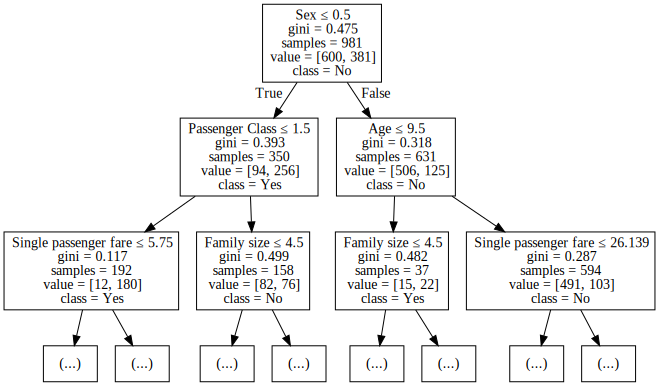

In [25]:
graph = graphviz.Source(
    tree.export_graphviz(titanic_model,
                         max_depth=2,
                         feature_names=X_train.columns,
                         class_names=['No', 'Yes'],
                         special_characters=True))
graph

# Predicting using cross-validation method

In [26]:
kf = KFold(shuffle=True, random_state=2020)

m_best = None
best_score = 0

for train_index, valid_index in kf.split(X_train, y_train):
    X_subtrain, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_subtrain, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    model = DecisionTreeClassifier(max_depth=7)
    model.fit(X_subtrain, y_subtrain)
    
    y_pred = model.predict(X_valid)    
    score = accuracy_score(y_valid, y_pred)

    if score > best_score:
        best_sccore = score
        m_best = model

In [27]:
y_res = m_best.predict(X_test)

In [28]:
print(f'accuracy_score: {accuracy_score(y_test, y_res):.2f}')

accuracy_score: 0.83


In [29]:
cm = pd.DataFrame(confusion_matrix(y_test, y_res), 
                  columns=["Actualy Survived", "Actualy Not Survived"],
                  index=["Predicted Survived", "Predicted Not Survived"])
cm

,Actualy Survived,Actualy Not Survived
Predicted Survived,194,15
Predicted Not Survived,40,79


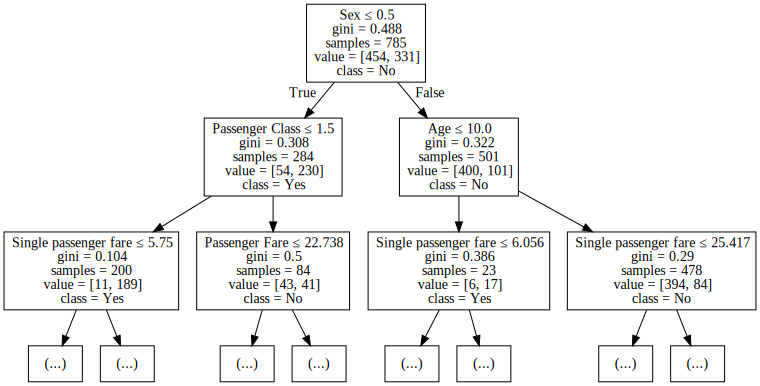

In [30]:
graph = graphviz.Source(
    tree.export_graphviz(m_best,
                         max_depth=2,
                         feature_names=X_train.columns,
                         class_names=['No', 'Yes'],
                         special_characters=True))
graph